In [3]:
import numpy as np
import glob
import os
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
#import stagnation.variables as va
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree

In [322]:
def gaussian(x, sig): #fonction de Gauss utlisé pour la normalisation et le calcul des poids de chaque points
    return 1/(sig*np.sqrt(2*np.pi))*np.exp(-1/2*(x/sig)**2)

In [323]:
L = 120 #box size
dx = 120/2**9 #minimum grid size
print(dx)
R0 = 8 #bubble equivalent radius
folderfig='/home/turbots/Documents/figure/'
eps = 7.8 #mean dissipation without the bubble
rho  = 1 #fluid density (taken as reference)
sig=dx/2

0.234375


In [324]:
pref = 2*rho*eps**(2/3)*(2*R0)**(5/3)
print(pref,pref/8)

799.1464389491427 99.89330486864284


In [325]:
def expo_decr(x,a,b,cte):
    return np.exp((-1/a)*x+b)+cte

In [326]:
folds = glob.glob('Re*') # we pick up all the files that start with Re and put them in folds

In [327]:
len(folds)# lenght of folds


422

In [328]:
folds0 = 'Re55t140-l9-1120-3-dump'
filesdissint = glob.glob(folds0+ '/localstats_[!f]*')
filesdissext = glob.glob(folds0 + '/localstats_fluid*')
filesinterf = glob.glob(folds0 + '/inter*.dat')
        
    

import warnings

with warnings.catch_warnings():#to remove warnings associated to the fact that some files are empty.
    warnings.simplefilter("ignore") 
    dataint = np.zeros([0, 7], dtype=float)
    dataext = np.zeros([0, 6], dtype=float)
    interf = np.zeros([0, 10], dtype=float)
    bubble = np.zeros([0, 12], dtype=float)
    stat = np.zeros([0, 8], dtype=float)
    vit_in = np.zeros([0,17], dtype=float)
    vit_interf = np.zeros([0,17], dtype=float)
    vit_out = np.zeros([0,16], dtype=float)
        


    for file in filesdissint:
        try:
            datatemp = np.loadtxt(file, skiprows=2)
        except:
            datatemp = np.loadtxt(file, skiprows=1)
        if datatemp.shape !=(0,):
            dataint = np.vstack((dataint, datatemp))

    for file in filesinterf:
        datatemp = np.loadtxt(file, skiprows=1)
        if datatemp.shape !=(0,):
            interf = np.vstack((interf, datatemp))

    for file in filesdissext:
        try:
            datatemp = np.loadtxt(file, skiprows=1)
        except:
            datatemp = np.loadtxt(file, skiprows=0)
        if datatemp.shape !=(0,):
            dataext = np.vstack((dataext, datatemp))

try:
    datatemp = np.loadtxt(folds0 +'/bubbles.dat', skiprows=1)
except:
    datatemp = np.loadtxt(folds0 +'/bubbles.dat', skiprows=0)
if datatemp.shape !=(0,):
    bubble = np.vstack((bubble,datatemp))
    
    
try:
    datatemp = np.loadtxt(folds0 +'/stats.dat', skiprows=1)
except:
    datatemp = np.loadtxt(folds0 +'/stats.dat', skiprows=0)
if datatemp.shape !=(0,):
    stat = np.vstack((stat,datatemp))
    


In [329]:
def calculate_normale(points,interf_points,region_index):
    
    normale=np.zeros([len(points),3])
    
    normale[:,:] = points[:,:] - interf_points[:,:][region_index]
    norm = np.sqrt(np.sum(normale[:,:]**2 , axis=1))
    normale /= norm[:,np.newaxis]
    
    return normale


In [330]:
def calculate_orthogonal_vectors(v):
    # Générer un vecteur aléatoire de même dimension que v
    random_vector = np.random.randn(len(v))
    
    # Calculer le produit vectoriel entre v et le vecteur aléatoire
    cross_product = np.cross(v, random_vector)
    
    # Calculer le produit vectoriel entre v et le produit vectoriel précédent
    orthogonal_vector = np.cross(v, cross_product)
    
    # Normaliser les vecteurs
    cross_product_normalized = cross_product / np.linalg.norm(cross_product)
    orthogonal_vector_normalized = orthogonal_vector / np.linalg.norm(orthogonal_vector)
    
    return cross_product_normalized, orthogonal_vector_normalized

In [332]:
#pour chaque normale, on calcule les vecteurs tangentielles correspondant

tangente1,tangente2 = np.zeros([len(interf),3]), np.zeros([len(interf),3])
i=0
for v in interf[:,7:10]:
    tangente1[i,:],tangente2[i,:] = calculate_orthogonal_vectors(v)
    i+=1


In [333]:
# on enlève les petites bulles parasites liées à des problèmes de simulations et qui peuvent fausser les résultats

maskint=(dataint[:,0]>-1)
maskinterf=(interf[:,0]>-1)

print(30*dx)
for bulle in bubble:
    if bulle[3]<30*dx: #la bulle est plus petite que 30 cellules ie pas une "bulle"
        j=bulle[2]
        maskint=np.logical_and(maskint,dataint[:,0][:]!=j)
        maskinterf=np.logical_and(maskinterf,interf[:,0][:]!=j)
print(dataint[:,0].size,maskint.size) 

7.03125
27635 27635


In [334]:
# mask_vit_in=(vit_in[:,0]<600)
# mask_vit_interf=(vit_interf[:,0]<600)

# print(30*dx)
# for bulle in bubble:
#     if bulle[3]<30*dx: #la bulle est plus petite que 30 cellules ie pas une "bulle"
#         j=bulle[2]
#         mask_vit_in=np.logical_and(mask_vit_in,vit_in[:,0][:]!=j)
#         mask_vit_interf=np.logical_and(mask_vit_interf,vit_interf[:,0][:]!=j)

In [335]:
# on calcule approximativement la position du centre de la bulle et on l'utilise pour recentrer les points afin que
#la bulle ne soit pas coupé à travers le domaine. Puis on recalcule le pc (position center)

pc = np.mean(dataint[:, 1:4][maskint], axis=0)# approximate position center
# pc2= np.mean(vit_in[:, 1:4][mask_vit_in], axis=0)
print(pc)
dataint[:, 1:4] = np.mod(dataint[:, 1:4] - pc + L/2, L) - L/2 #shift data position
dataext[:, 0:3] = np.mod(dataext[:, 0:3] - pc + L/2, L) - L/2 #shift data position
interf[:, 1:4] = np.mod(interf[:, 1:4] - pc + L/2, L) - L/2 #shift interface position

pc = np.mean(dataint[:, 1:4], axis=0)# approximate position center
# pc2= np.mean(vit_in[:, 1:4][mask_vit_in], axis=0)
print(pc)


[13.50378608 31.53823599 33.00839057]
[9.48453064e-14 7.53736329e-13 3.11961043e-13]


In [336]:
# on masque les points extérieures de la bulle qui sont trop éloigné du centre de la bulle pour réduire le temps 
# de calcul et car on ne s'intéresse qu'a ce qu'il se passe proche de la bulle
maskext=((dataext[:,0]-pc[0])**2+(dataext[:,1]-pc[1])**2+(dataext[:,2]-pc[2])**2<(25*R0**2)) #5*R0


In [337]:
# on crée un masque pour étudier le problème en 1D et en 2D

z = np.mean(dataint[:, 3][maskint])
dz=0.5
y=np.mean(dataint[:, 2][maskint])
dy=0.5

indicez= np.logical_and(dataint[:, 3]>z-dz, dataint[:, 3]<z+dz )
indicey= np.logical_and(dataint[:, 2]>y-dy, dataint[:, 2]<y+dy )
maskint1d=np.logical_and(indicey,indicez)
maskint2d=np.logical_and(indicez,maskint) #masque 2d pour le champ de données intérieures
maskint1d=np.logical_and(maskint1d,maskint) #masque 1d pour le champ de données intérieures

indicez2= np.logical_and(dataext[:, 2]>z-dz, dataext[:, 2]<z+dz )
indicey2= np.logical_and(dataext[:, 1]>y-dy, dataext[:, 1]<y+dy )
maskext2d=np.logical_and(maskext,indicez2)#masque 2d pour le champ de données extérieures
maskext1d=np.logical_and(indicey2,indicez2)#masque 1d pour le champ de données extérieures
maskext1d=np.logical_and(maskext,maskext1d)

indicez3= np.logical_and(interf[:, 3]>z-dz, interf[:, 3]<z+dz )
indicey3= np.logical_and(interf[:, 2]>y-dy, interf[:, 2]<y+dy )
maskinterf2d=np.logical_and(indicez3,maskinterf)
maskinterf1d=np.logical_and(indicez3,indicey3)
maskinterf1d=np.logical_and(maskinterf,maskinterf1d)


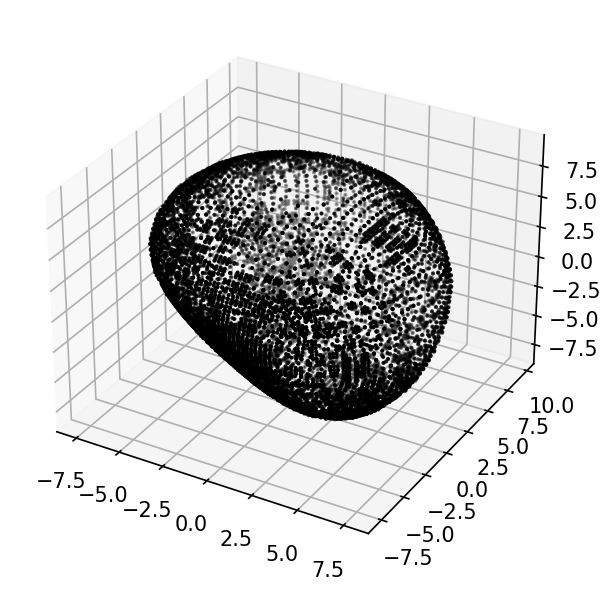

In [339]:
fig = plt.figure(dpi=150)
ax = plt.axes(projection='3d')
#np.mod(X - pc + L/2, L) - L/2
# p2=ax.scatter(dataint[:, 1], dataint[:, 2], dataint[:, 3], c=dataint[:,5], s=1)
ax.scatter(interf[:,1][maskinterf],interf[:,2][maskinterf],interf[:,3][maskinterf],color='k',s=1)
# plt.title('interface of the bubble')
# plt.savefig(folderfig + 'interface_solo_bubble.pdf',bbox_inches='tight')

In [340]:
# fig = plt.figure(dpi=150)
# ax = plt.axes(projection='3d')
# #np.mod(X - pc + L/2, L) - L/2
# p=ax.scatter(vit_interf[:, 1][mask_vit_interf], vit_interf[:, 2][mask_vit_interf], vit_interf[:, 3][mask_vit_interf], c=vit_interf[:,5][mask_vit_interf], s=1)
# plt.title('interface velocity vx')
# plt.plot(pc[0],pc[1],pc[2],color='r')
# # ax.scatter(interf[:,1][maskinterf],interf[:,2][maskinterf],interf[:,3][maskinterf],color='k')
# ax.set_xlabel('X ')
# ax.set_ylabel('Y ')
# ax.set_zlabel('Z ')
# fig.colorbar(p)


(-20.0, 20.0)

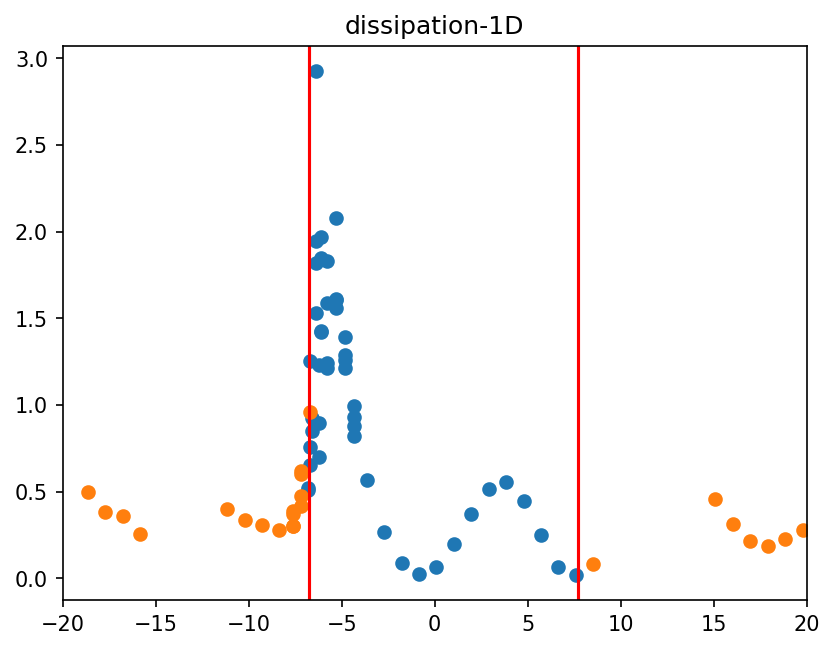

In [341]:
plt.figure(dpi=150)
plt.scatter(dataint[:, 1][maskint1d],dataint[:, 5][maskint1d])
plt.scatter(dataext[:, 0][maskext1d],dataext[:, 4][maskext1d]/25) #on divise par 25=rapport de viscosité air/eau
# délimite la position de la bulle
plt.axvline(min(interf[:,1][maskinterf1d]),color='r')
plt.axvline(max(interf[:,1][maskinterf1d]),color='r') 
plt.title('dissipation-1D')
plt.xlim(-20,20)

In [342]:
# plt.figure(dpi=150)
# plt.scatter(vit_in[:, 1][mask_vit_in_1d],vit_in[:, 7][mask_vit_in_1d]**2)
# plt.scatter(vit_out[:, 0][mask_vit_out_1d],vit_out[:, 6][mask_vit_out_1d]**2)
# # délimite la position de la bulle
# plt.axvline(min(interf[:,1][maskinterf1d]),color='r')
# plt.axvline(max(interf[:,1][maskinterf1d]),color='r') 
# plt.title('squared dvxdx-1D')
# plt.xlim(-20,20)

In [343]:
# fig = plt.figure(dpi=150)
# ax = plt.axes(projection='3d')
# #np.mod(X - pc + L/2, L) - L/2
# p=ax.scatter(v_norm_interf[:, 1][mask_vit_interf], v_norm_interf[:, 2][mask_vit_interf], v_norm_interf[:, 3][mask_vit_interf], c=v_norm_interf[:,-2][mask_vit_interf], s=1)
# plt.title('interface normal velocity magnitude')
# plt.plot(pc[0],pc[1],pc[2],color='r')
# # ax.scatter(interf[:,1][maskinterf],interf[:,2][maskinterf],interf[:,3][maskinterf],color='k')
# ax.set_xlabel('X ')
# ax.set_ylabel('Y ')
# ax.set_zlabel('Z ')
# fig.colorbar(p)

# fig = plt.figure(dpi=150)
# ax = plt.axes(projection='3d')
# #np.mod(X - pc + L/2, L) - L/2
# p=ax.scatter(v_tang_interf[:, 1][mask_vit_interf], v_tang_interf[:, 2][mask_vit_interf], v_tang_interf[:, 3][mask_vit_interf], c=v_tang_interf[:,-2][mask_vit_interf], s=1)
# plt.title('interface tangential velocity magnitude')
# plt.plot(pc[0],pc[1],pc[2],color='r')
# # ax.scatter(interf[:,1][maskinterf],interf[:,2][maskinterf],interf[:,3][maskinterf],color='k')
# ax.set_xlabel('X ')
# ax.set_ylabel('Y ')
# ax.set_zlabel('Z ')
# fig.colorbar(p)

In [344]:
voronoi_kdtree = cKDTree(interf[:, 1:4]) #fonction qui trace un diagramme de Voronoi. 
#Ce diagrame permet de crée des régions où sont regorupés tout les points les points proches 
#d'un point de l'interface. Ça permet de calculer la distance des points à l'interface

In [345]:
test_point_dist_ext, test_point_regions_ext = voronoi_kdtree.query(dataext[:, 0:3][maskext])
test_point_dist_int, test_point_regions_int = voronoi_kdtree.query(dataint[:, 1:4][maskint])


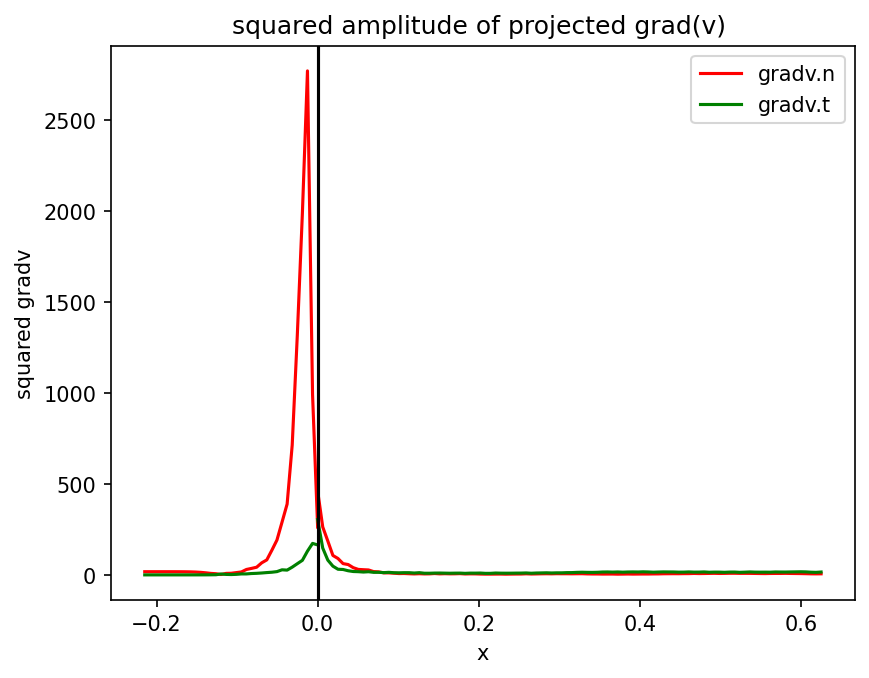

In [346]:
#test de la normalisation avec une fonction exponentielle
dist = np.linspace(0, 4*R0, 100)

weights = gaussian(test_point_dist_ext -dist[:, np.newaxis], sig)

expo=np.exp(test_point_dist_ext)

mean = np.sum(expo*weights*dataext[:, 5][maskext], axis=1)/np.sum(dataext[:, 5][maskext]*weights, axis=1)


In [347]:
#mean dissipation outside

dist = np.linspace(0, 4*16, 100)

weights = gaussian(test_point_dist_ext -dist[:, np.newaxis], sig)
#mean dissipation
meandiss_ext = np.sum(dataext[:, 4][maskext]*weights*dataext[:, 5][maskext], axis=1)/np.sum(dataext[:, 5][maskext]*weights,axis=1)

#mean dissipation inside

dist = np.linspace(0, 4*R0, 100)

weights = gaussian(test_point_dist_int -dist[:, np.newaxis], sig)
print(dataint[maskint].shape,weights.shape)
#mean dissipation
meandiss_int = np.sum(dataint[:, 5][maskint]*weights*dataint[maskint][:, -1], axis=1)/np.sum(dataint[maskint][:, -1]*weights,axis=1)

(27635, 7) (100, 27635)


/tmp/ipykernel_6504/2717145175.py:7: RuntimeWarning: invalid value encountered in divide
  meandiss_ext = np.sum(dataext[:, 4][maskext]*weights*dataext[:, 5][maskext], axis=1)/np.sum(dataext[:, 5][maskext]*weights,axis=1)
/tmp/ipykernel_6504/2717145175.py:16: RuntimeWarning: invalid value encountered in divide
  meandiss_int = np.sum(dataint[:, 5][maskint]*weights*dataint[maskint][:, -1], axis=1)/np.sum(dataint[maskint][:, -1]*weights,axis=1)


In [348]:
#normalisation de l'énergie cinétique à l'extérieure de la bulle
dist = np.linspace(0, 4*R0, 100)
# sig = np.min(dataext[:, -1][maskext])**(1/3)/8 #standard deviation
print(sig)
weights = gaussian(test_point_dist_ext -dist[:, np.newaxis], sig)
#mean kinectic energy outside
print(weights.size,dataext[:, 3][maskext].size,dataext[:, 5][maskext].size)
meankin_ext = np.sum(dataext[:, 3][maskext]*weights*dataext[:, 5][maskext], axis=1)/np.sum(dataext[:, 5][maskext]*weights,axis=1)

# normalisation de l'énergie cinétique à l'intérieur de la bulle
dist = np.linspace(0, 4*R0, 100)
weights = gaussian(test_point_dist_int -dist[:, np.newaxis], sig)
#mean dissipation
meankin_int = np.sum(dataint[maskint][:, 4]*weights*dataint[maskint][:, -1], axis=1)/np.sum(dataint[maskint][:, -1]*weights,axis=1)

0.1171875
18510900 185109 185109


/tmp/ipykernel_6504/242047929.py:14: RuntimeWarning: invalid value encountered in divide
  meankin_int = np.sum(dataint[maskint][:, 4]*weights*dataint[maskint][:, -1], axis=1)/np.sum(dataint[maskint][:, -1]*weights,axis=1)


1.2792252182048762


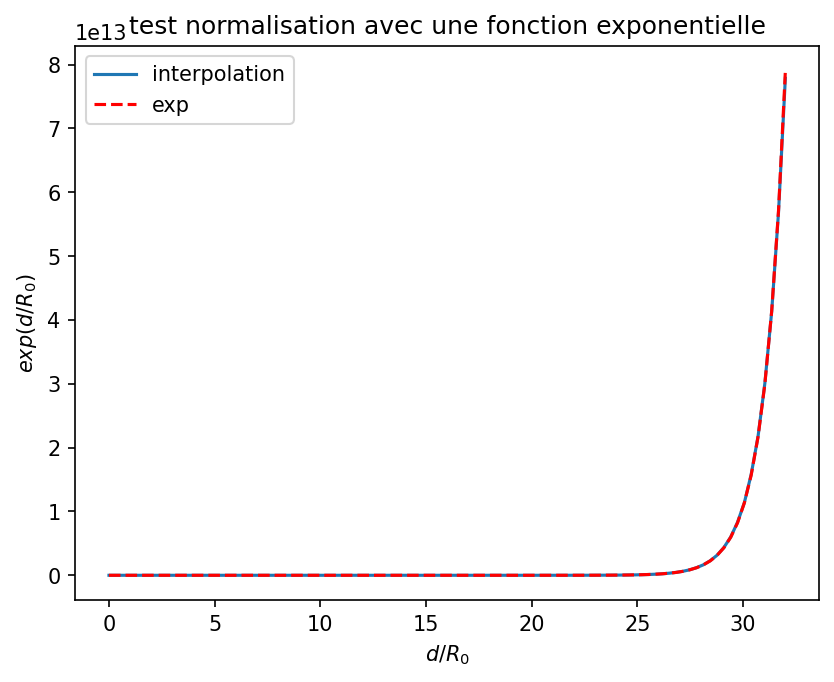

In [349]:
plt.figure(dpi=150)
plt.plot(dist,mean, label = 'interpolation')
plt.xlabel('$d/R_0$')
plt.ylabel('$exp(d/R_0)$')
plt.plot(dist,np.exp(dist),color='r',linestyle='--',label = 'exp')
plt.title('test normalisation avec une fonction exponentielle')
plt.legend()
plt.savefig(folderfig+'test_normalisation.pdf')
print(mean[0])



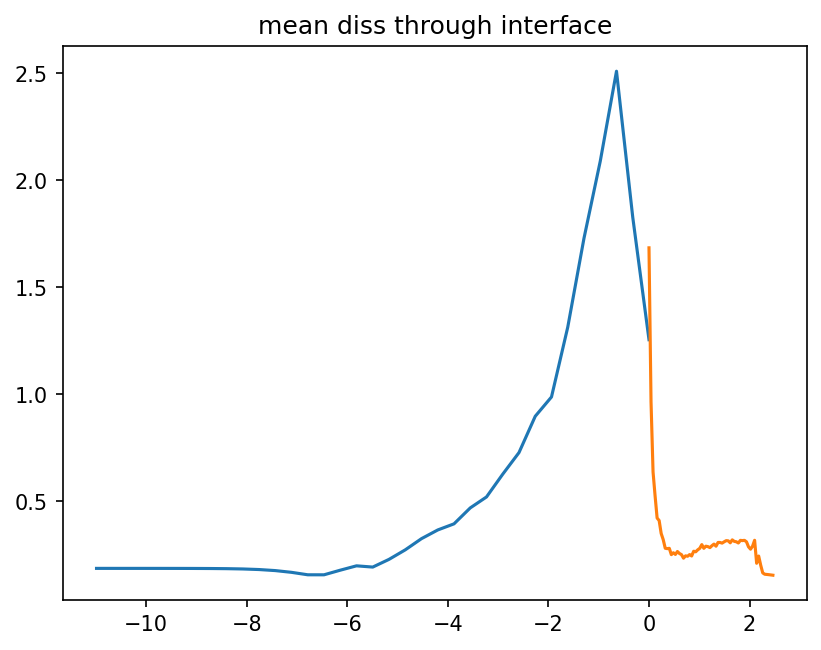

In [350]:
plt.figure(dpi=150)
plt.title('mean diss through interface')
plt.plot(dist*(-1), meandiss_int)
plt.plot(dist/R0,meandiss_ext/25)
# plt.xlim(-0.5,0.5)
# plt.savefig(folderfig + 'dissipation_interface.single_simu.pdf',bbox_inches='tight')

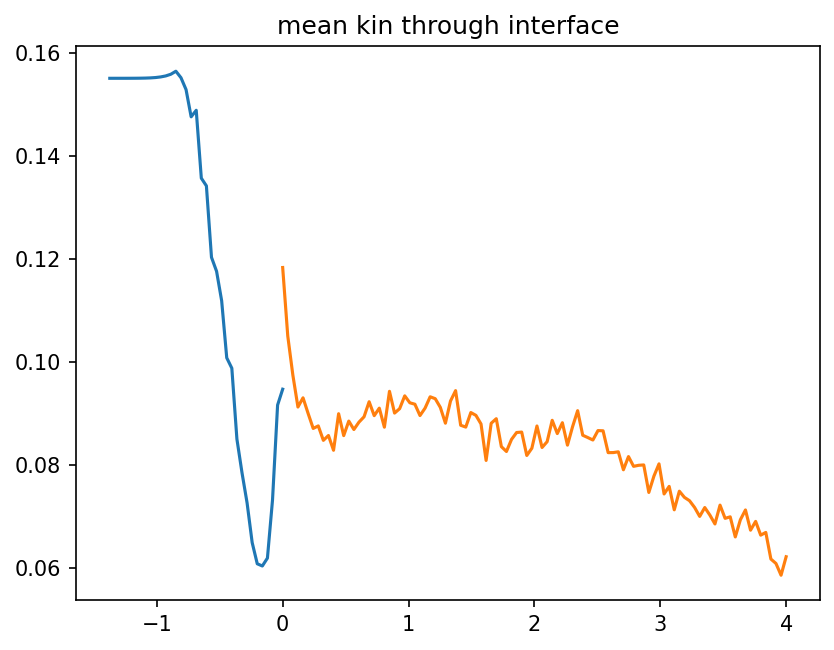

In [351]:
plt.figure(dpi=150)
plt.title('mean kin through interface')
plt.plot(dist*(-1)/R0, meankin_int)
plt.plot(dist/R0,meankin_ext/850)
# plt.xlim(-0.5,0.5)
# plt.savefig(folderfig + 'dissipation_interface.single_simu.pdf',bbox_inches='tight')

In [352]:
def loadfiles(filename):
    '''
    Load local_stats, localstats_fluid and interface files knowing the folder direction. 
    Return datain, dataout & interf
    '''
    import warnings

    with warnings.catch_warnings():#to remove warnings associated to the fact that some files are empty.
        warnings.simplefilter("ignore")    
        filesdissint = glob.glob(filename + '/localstats_[!f]*')
        filesdissext = glob.glob(filename + '/localstats_fl*')
        filesinterf = glob.glob(filename + '/inter*.dat')
#         filestat = glob.glob(filename + '/stats.dat')

        data1 = np.zeros([0, 7], dtype=float)
        data2 = np.zeros([0, 6], dtype=float)
        interf = np.zeros([0, 10], dtype=float)
        stat = np.zeros([0,8], dtype=float)
        bubble = np.zeros([0,12], dtype=float)
        

        with open(filename + '/stats.dat', 'r') as f:
            stat=[]
            for line in f:
                if "t" in line:
    #         si on lit "t", on saute la ligne, ie on saute la 1er ligne
                    continue
                data=line.split()
                for i in np.arange(len(data)):
                    temp=float(data[i])
                    stat.append(temp)

    

        for file in filesdissint:
            try:
                datatemp = np.loadtxt(file, skiprows=2)
            except:
                datatemp = np.loadtxt(file, skiprows=1)
            if datatemp.shape !=(0,):
                data1 = np.vstack((data1, datatemp))

        for file in filesinterf:
            datatemp = np.loadtxt(file, skiprows=1)
            if datatemp.shape !=(0,):
                interf = np.vstack((interf, datatemp))
                
        for file in filesdissext:
            try:
                datatemp = np.loadtxt(file, skiprows=1)
            except:
                datatemp = np.loadtxt(file, skiprows=0)
            if datatemp.shape !=(0,):
                data2 = np.vstack((data2, datatemp))
        
        datatemp=np.loadtxt(filename + '/bubbles.dat',skiprows=1)
        if datatemp.shape !=(0,):
                bubble = np.vstack((bubble,datatemp))



        return data1, data2, interf, stat, bubble

In [353]:
def compute_dist(interface_points, interface_normal, test_points):
    '''
    Compute distance, knowing the interfacial points coordinates, the interface normal 
    and the position of the inside points. 
    '''
    #Voronoi diagram
    voronoi_kdtree = cKDTree(interface_points)
    #Region of the test points
    test_point_dist, test_point_regions = voronoi_kdtree.query(test_points)
    #distance with scalar product with the normal
    distance = np.abs(np.sum((test_points-interface_points[test_point_regions])*interface_normal[test_point_regions], axis=1))
    positif=(np.sum((test_points-interface_points[test_point_regions])*interface_normal[test_point_regions], axis=1)>=0)

    return test_point_dist, test_point_regions, positif

In [235]:
4/50

0.08

In [206]:
dist = np.linspace(0, 8, 100)  
dist2 = np.linspace(0, 40, 500) 
dico_donnees={}
dissipationint = {}
kineticint = {}
dissipationext = {}
kineticext = {}
occ_gamma_dump={}

for fold in folds:
    
    data,data2, interf, stat, bubble = loadfiles(fold);
    #test whether the bubble broke or not. If so there are several bubbles and so 
    # bubble number can be larger than 0. 
    print(fold)
    if 1 in data[:, 0]:
        print('break')
        print(np.max(data[:, 0]))
        continue
    

    #recenter
    pc = np.median(data[:, 1:4], axis=0)

#     point intérieurs
    maskint=(data[:,0]>-1)
    maskinterf=(interf[:,0]>-1)
#     print(bubble)
    for bulle in bubble:
        if bulle[3]<30*dx: #la bulle est plus petite que 30 cellules ie pas une "bulle"
            j=bulle[2]
            maskint=np.logical_and(maskint,data[:,0][:]!=j)
            maskinterf=np.logical_and(maskinterf,interf[:,0][:]!=j)
            
    # on recentre les points
    data[:, 1:4] = np.mod(data[:, 1:4][maskint] - pc + L/2, L) - L/2
    interf[:, 1:4] = np.mod(interf[:, 1:4][maskinterf] - pc + L/2, L) - L/2
    #compute distance
    #Voronoi diagram
    voronoi_kdtree = cKDTree(interf[:,1:4][maskinterf])
    #Region of the test points
    test_point_dist, test_point_regions = voronoi_kdtree.query(data[:,1:4][maskint])
    normale = calculate_normale(data[:,1:4][maskint],interf[:,1:4][maskinterf],test_point_regions)
    #distance with scalar product with the normal
    positif=(np.sum((data[:,1:4][maskint]-interf[:,1:4][test_point_regions])*normale, axis=1)>=0)
    maskint=np.logical_and(maskint,positif)
   
    


    #compute avg
#     sig = np.min(data[:, -1])**(1/3)/2
    weights = gaussian(test_point_dist[maskint] -dist[:, np.newaxis], sig)
    norm = np.sum(data[:, 6][maskint]*weights, axis=1)
    meandiss = np.sum(data[:, 5][maskint]*weights*data[:, 6][maskint], axis=1)/norm #mean dissip
    meankin = np.sum(data[:, 4][maskint]*weights*data[:, 6][maskint], axis=1)/norm #mean kinetic energy
    

    if float(fold.split('-')[2])==8:
        gamma = float(fold.split('-')[3])
    else:
        gamma = float(fold.split('-')[2])

    if gamma not in dissipationint:
        dissipationint[gamma] = np.zeros([3, len(dist)])
        kineticint[gamma] = np.zeros([3, len(dist)])
        occ_gamma_dump[gamma] = 0
        

    ind = dist<np.max(test_point_dist)
    dissipationint[gamma][0, :][ind] += meandiss[ind]#avg
    dissipationint[gamma][1, :][ind] += meandiss[ind]**2 #std
    dissipationint[gamma][2, :][ind] += 1#nbr

    kineticint[gamma][2, :][ind] += 1
    kineticint[gamma][0, :][ind] += meankin[ind]
    kineticint[gamma][1, :][ind] += meankin[ind]**2  
    
    occ_gamma_dump[gamma] +=1
    
    with open( fold +  '/dissint.pkl', 'wb') as f:
        pickle.dump(dissipationint, f)

#     points extérieurs

    data2[:, 0:3] = np.mod(data2[:, 0:3] - pc + L/2, L) - L/2
    pc=np.mean(data[:,1:4], axis=0)
    index =((data2[:,0]-pc[0])**2+(data2[:,1]-pc[1])**2+(data2[:,2]-pc[2])**2<(36*R0**2)) #6*R0
    
    #compute distance
    test_point_dist, test_point_regions = voronoi_kdtree.query(data2[:,0:3][index])
#     normale = calculate_normale(data2[:,0:3][index],interf[:,1:4][maskinterf],test_point_regions)




    #compute avg
    weights = gaussian(test_point_dist -dist2[:, np.newaxis], sig)
    norm = np.sum(data2[:, 5][index]*weights, axis=1)
    meandiss = np.sum(data2[:,4][index]*weights*data2[:, 5][index], axis=1)/norm
    meankin = np.sum(data2[:,3][index]*weights*data2[:, 5][index], axis=1)/norm
    
   
    
    if gamma not in dissipationext:
        dissipationext[gamma] = np.zeros([3, len(dist2)])
        kineticext[gamma] = np.zeros([3, len(dist2)])


    ind = dist2<np.max(test_point_dist) #
    dissipationext[gamma][0, :][ind] += meandiss[ind]#avg
    dissipationext[gamma][1, :][ind] += meandiss[ind]**2 #std
    dissipationext[gamma][2, :][ind] += 1#nbr

    kineticext[gamma][2, :][ind] += 1
    kineticext[gamma][0, :][ind] += meankin[ind]
    kineticext[gamma][1, :][ind] += meankin[ind]**2
        
    with open( fold +  '/dissext.pkl', 'wb') as f:
        pickle.dump(dissipationext, f)

    
for tab in [dissipationint, kineticint]:
    for key in tab:
        tab[key][0, :] /= np.where(tab[key][2, :]>0, tab[key][2, :], 1) #on divise par le nombre d'occurence pour moyenné
        tab[key][1, :] /= np.where(tab[key][2, :]>0, tab[key][2, :], 1)
        tab[key][1, :] -= tab[key][0, :]**2
        tab[key][1, :] = np.sqrt(tab[key][1, :])

for tab in [dissipationext, kineticext]:
    for key in tab:
        tab[key][0, :] /= np.where(tab[key][2, :]>0, tab[key][2, :], 1)
        tab[key][1, :] /= np.where(tab[key][2, :]>0, tab[key][2, :], 1)
        tab[key][1, :] -= tab[key][0, :]**2
        tab[key][1, :] = np.sqrt(tab[key][1, :])
        

        

Re55t140-l9-8-3000-dump_44902-dump_44902
Re55t140-l9-8-3000-2-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-1750-4-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_59013-dump_59013


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-1120-2-dump
Re55t200-l9-1120-4-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_83039


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-400-3end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-1120-5end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_51678
Re55t140-l9-8-2240-2-dump_70499-dump_70499


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t180-l9-1120-5end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-1120-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-4-dump_111276-dump_111276


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t180-l9-1120-4-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_1-dump_1
Re55t140-l9-8-2240-2-dump_57959


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-1750-dump_32018


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_37051-dump_37051


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-2240-dump_0-dump_0
Re55t140-l9-8-2240-4-dump_123816-dump_123816
Re55t120-l9-8-400-dump_27098-dump_27098


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-2240-dump_54813-dump_54813


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-560-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_52413-dump_52413


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-4-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-4-dump_114411


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_76769


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_37759-dump_37759


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_40409


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_79904


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-4-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_41734


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_42273-dump_42273


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_54817


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_36425


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_48441


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_45408


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-3-dump_95716-dump_95716


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-1120-5-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_74911-dump_74911


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_49595-dump_49595
Re55t140-l9-8-2240-3-dump_98725


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_29733


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_67364-dump_67364


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-2-dump_77565-dump_77565


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-3000-4-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_89320-dump_89320


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_76769-dump_76769


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-400-4end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-3000-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-1750-4end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_49793-dump_49793


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_35100


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-4-dump_139262-dump_139262


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-4-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-275-2-dump
break
3.0
Re55t120-l9-8-400-2-dump_67085
Re55t200-l9-1750-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_67415-dump_67415


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-4-dump_135634-dump_135634


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-1120-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_63667-dump_63667


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_57762


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-2240-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_28423-dump_28423


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_67364


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_44392


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-2-dump_63053-dump_63053


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-dump_52158-dump_52158


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-1750-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_54817-dump_54817


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-275-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_39084


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-3000-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_25693-dump_25693


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_64435


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_73133-dump_73133


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-5-dump_146528-dump_146528


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_45408-dump_45408


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-1750-4-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_59087


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-400-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_55112


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-4-dump_117546


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-2240-5end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_73634


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t180-l9-400-3-dump
break
2.0
Re55t120-l9-8-400-dump_37759


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_47090-dump_47090


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_26598-dump_26598


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_1
Re55t120-l9-8-400-dump_25693-dump_25693


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-275-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-2-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_60455


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-1120-4-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-dump_30390-dump_30390


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t180-l9-1120-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-2-dump_66681-dump_66681


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t180-l9-1120-5-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_46459-dump_46459


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-3-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-1750-dump_37560


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_89320


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_39084-dump_39084


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t180-l9-400-4-dump
Re55t140-l9-8-2240-2-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_61094


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_52462


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-1750-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-800-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-3-dump_88460-dump_88460


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_32868-dump_32868


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_56437


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-5-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-1120-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_41734-dump_41734


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t180-l9-1120-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-400-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_40409-dump_40409


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_49793


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-1750-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-1750-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-2240-dump_29733-dump_29733


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-1750-dump_43102


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-2240-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-560-3end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-dump_41274-dump_41274


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-2-dump_59425-dump_59425


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_47090


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-dump_34018-dump_34018


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_78659-dump_78659


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_26177-dump_26177
Re55t140-l9-8-560-dump_44891-dump_44891


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_26075-dump_26075


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_55877-dump_55877
Re55t140-l9-8-800-2-dump_59919-dump_59919


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_38619-dump_38619


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_64435-dump_64435


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_95590-dump_95590
Re55t140-l9-8-560-2-dump_68429-dump_68429


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_35483-dump_35483


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-dump_37646-dump_37646


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_32868


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-2240-dump_26598-dump_26598


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_32347-dump_32347


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-275-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-2240-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_86185


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-1120-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_65760


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_61780-dump_61780


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-400-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_32450-dump_32450


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t180-l9-275-2-dump
break
4.0
Re55t140-l9-8-800-2-dump_80533-dump_80533


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-dump_48530-dump_48530


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_64229-dump_64229


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-3-dump_84832-dump_84832


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_57445-dump_57445


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_36003


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-2240-4-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-4-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_28423-dump_28423


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_45765-dump_45765


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_42273


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_83039-dump_83039


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_32450-dump_32450


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_39295-dump_39295


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_0
Re55t140-l9-8-2240-3-dump_92455-dump_92455


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-800-3end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-400-dump
break
3.0
Re55t200-l9-1750-4-4-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_40187-dump_40187


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_48665-dump_48665


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_24350


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_57959-dump_57959


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-800-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_27098


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-560-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_39138-dump_39138


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_31073-dump_31073


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_48027-dump_48027


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-3-dump_110228-dump_110228
Re55t120-l9-1120-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_70499


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-2240-dump_45408-dump_45408


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-2240-5-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_0-dump_0
Re55t140-l9-8-1750-dump_45873


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_36425-dump_36425


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-2240-dump_39138-dump_39138


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-3-dump_102972-dump_102972


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_36003-dump_36003


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-3-dump_113856-dump_113856


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-1750-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_63725-dump_63725


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_77837-dump_77837
Re55t200-l9-2240-6end-dump
Re55t140-l9-8-2240-2-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_82407-dump_82407


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_45765-dump_45765


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_56161-dump_56161


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-4-dump_117546-dump_117546


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-400-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-800-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_36425-dump_36425


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_60589-dump_60589


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t180-l9-400-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-3000-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_52462-dump_52462


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-560-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_63110-dump_63110


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_108130


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_54309-dump_54309


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-1750-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_61780


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-1750-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_29748-dump_29748


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-275-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_46791-dump_46791
Re55t140-l9-8-800-dump_41169-dump_41169


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_45765


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_1
Re55t140-l9-1120-3-dump
Re55t140-l9-8-3000-5-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-4-dump_117494-dump_117494


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_76269-dump_76269


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-3-dump_86166-dump_86166


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_25693


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-3-dump_84292-dump_84292


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-2-dump_70309-dump_70309


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-4-dump_130086-dump_130086


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-4-dump_120681-dump_120681


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_33915-dump_33915


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-4-dump_121122-dump_121122


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-2240-dump_42273-dump_42273


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-1120-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_43067-dump_43067


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_40409-dump_40409


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-275-dump
break
2.0
Re55t140-l9-2240-dump_51678-dump_51678
Re55t140-l9-8-560-2-dump_69997-dump_69997


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_28423


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-2240-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_74701-dump_74701


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-2240-5-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-1120-4end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_48543


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_51118-dump_51118


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-4-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_55112-dump_55112


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-3-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-560-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_98725-dump_98725


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-2240-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-3000-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_57762-dump_57762


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t180-l9-400-4end-dump
break
1.0
Re55t140-l9-8-800-2-dump_69289-dump_69289


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_39084-dump_39084


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_29748


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_54813


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_63110


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_53787-dump_53787


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_48441-dump_48441


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-275-dump
break
5.0
Re55t120-l9-400-dump_44392-dump_44392


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-1750-dump_51415


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_33673-dump_33673


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-2240-dump_32868-dump_32868


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-400-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_101860


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_48543-dump_48543


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-2-dump_81193-dump_81193


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-800-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_35100-dump_35100


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_43067


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_32450


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_33775-dump_33775


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-4-dump_128378-dump_128378


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_0-dump_0
Re55t140-l9-8-560-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_66861-dump_66861


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_51118


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-1750-dump_54186


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_35100-dump_35100


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_27643-dump_27643


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t180-l9-275-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_60455-dump_60455


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-2240-4-dump
Re55t120-l9-8-400-2-dump_65760-dump_65760


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-560-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-3-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_61793-dump_61793


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-1120-4-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_65293-dump_65293


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_86185-dump_86185


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_59087-dump_59087


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_51163-dump_51163


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_31073


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_47090-dump_47090


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-1120-4-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_51678-dump_51678
Re55t140-l9-8-2240-3-dump_95590
Re55t140-l9-8-2240-dump_54813-dump_54813


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-800-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-4-dump_132006-dump_132006
Re55t120-l9-400-dump_24350-dump_24350


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-1120-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-3-dump_1-dump_1
Re55t140-l9-8-800-2-dump_65541-dump_65541


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_92455


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-3-dump_92088-dump_92088


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_73037-dump_73037


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_79904-dump_79904


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-2240-dump_36003-dump_36003


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-1120-4end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-560-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_44392-dump_44392


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_67085-dump_67085
Re55t200-l9-2240-6-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-2240-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_37759-dump_37759


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_43043-dump_43043


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_104995


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_50539-dump_50539


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_58045-dump_58045


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-275-3end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_43067-dump_43067


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_101860-dump_101860


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-1750-dump_34789


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_104995-dump_104995


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-1120-4end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_29211-dump_29211


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_1-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_71163-dump_71163


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-dump_0-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-1750-dump_29247


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-1120-2-dump
Re55t160-l9-1750-4end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t180-l9-1120-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_1


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-3-dump_106600-dump_106600


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_52731-dump_52731


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-800-3end-dump
Re55t140-l9-8-560-dump_43323-dump_43323


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-4-dump_126951-dump_126951


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_35547-dump_35547


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-1750-dump_48644


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-3-dump_108130-dump_108130


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_30779-dump_30779


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-400-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-3-dump_99344-dump_99344


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_24350-dump_24350


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_0


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-3000-4-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-dump_41755-dump_41755


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-400-4-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_26598


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_39138


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_31799-dump_31799


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_33775-dump_33775


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_62157-dump_62157


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-1750-dump_26476


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-3-dump_88040-dump_88040


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-560-3end-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-3000-3-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t180-l9-400-2-dump
break
1.0
Re55t140-l9-8-3000-2-dump_55797-dump_55797


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-dump_33775


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_64229


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-2240-dump_1-dump_1
Re55t140-l9-8-800-dump_54287-dump_54287


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-1750-dump_40331


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_29748-dump_29748


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_37421-dump_37421


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-4-dump_126951


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-560-2-dump_71565-dump_71565


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-1120-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_29733-dump_29733


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-dump_26762-dump_26762


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_53787


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t200-l9-3000-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_61094-dump_61094


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_31073-dump_31073


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_28051-dump_28051


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-8-400-2-dump_56437-dump_56437


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_76785-dump_76785


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-2-dump_73937-dump_73937


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-dump_1-dump_1
Re55t140-l9-2240-dump_48543-dump_48543


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_27098-dump_27098


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t120-l9-400-dump_41734-dump_41734


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-1120-2-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t160-l9-800-dump


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-3000-4-dump_124750-dump_124750


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-4-dump_114411-dump_114411


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_44917-dump_44917


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_29925-dump_29925
Re55t140-l9-8-3000-4-dump_142890-dump_142890


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-2240-2-dump_73634-dump_73634


/tmp/ipykernel_6504/1651553322.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


In [248]:
lgammas = []
for key in dissipationint:
    lgammas.append(key)
print(lgammas)
gamma_sort=np.sort(lgammas)
print(gamma_sort)
# lgammas = np.sort(lgammas)
we=[]

print(lgammas[1],pref/8)
for i in np.arange(8):
    w=pref/gamma_sort[i]

    we.append(w)
we=np.sort(we)
print(we)

[3000.0, 1750.0, 560.0, 1120.0, 2240.0, 400.0, 800.0, 275.0]
[ 275.  400.  560.  800. 1120. 1750. 2240. 3000.]
1750.0 99.89330486864284
[0.26638215 0.3567618  0.45665511 0.71352361 0.99893305 1.42704721
 1.9978661  2.90598705]


In [251]:
total = 0
i=0
for key in dissipationext:
    print(occ_gamma_dump[key], key, we[i])
    total += occ_gamma_dump[key]
    i+=1
print(total)

52 3000.0 0.2663821463163809
24 1750.0 0.3567618031022959
46 560.0 0.4566551079709387
27 1120.0 0.7135236062045918
106 2240.0 0.9989330486864284
105 400.0 1.4270472124091835
48 800.0 1.9978660973728568
6 275.0 2.9059870507241556
414


In [209]:
# for tab in [dissipationint, kineticint]:
#     for key in tab:
#         tab[key][0, :] *= np.where(tab[key][2, :]>0, tab[key][2, :], 1) #on divise par le nombre d'occurence pour moyenné
#         tab[key][1, :] *= np.where(tab[key][2, :]>0, tab[key][2, :], 1)
#         tab[key][1, :] += tab[key][0, :]**2
#         tab[key][1, :] = np.sqrt(tab[key][1, :])

# for tab in [dissipationext, kineticext]:
#     for key in tab:
#         tab[key][0, :] *= np.where(tab[key][2, :]>0, tab[key][2, :], 1)
#         tab[key][1, :] *= np.where(tab[key][2, :]>0, tab[key][2, :], 1)
#         tab[key][1, :] += tab[key][0, :]**2
#         tab[key][1, :] = np.sqrt(tab[key][1, :])

/tmp/ipykernel_6504/775377535.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)


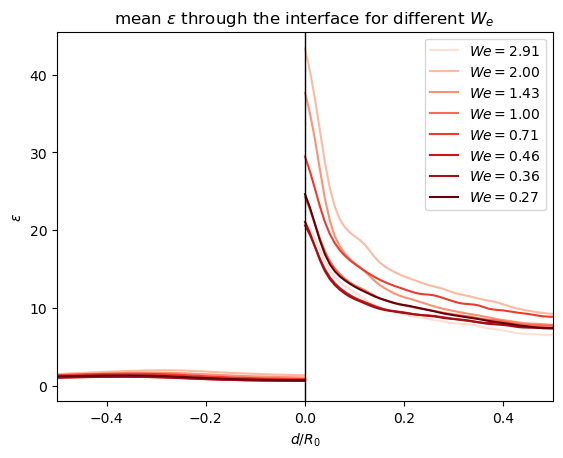

In [321]:
cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)
i=0

for key in gamma_sort:
    if key<700:
        pass
    if key==8:
        continue
#     indicemax=np.argmax(dissipationint[key][0,:])
#     indice=np.logical_and(-dist<-0.04*8,-dist>-0.16*8)
#     print(key, int(dissipationint[key][2, 0]))
#     print(key, int(dissipationext[key][2, 0])
    line, = plt.plot(dist2/R0, dissipationext[key][0,:],color=cmap(i+1),label = f'$We = {pref/key:.2f}$')
    line, = plt.plot(dist/R0*(-1), dissipationint[key][0,:],color=cmap(i+1))

    i+=1

plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$\epsilon$')
plt.xlim(-0.5,0.5)
plt.axvline(0,color='k',lw=1)
plt.title(r'mean $\epsilon $ through the interface for different $W_e$ ')
plt.savefig(folderfig + 'mean_dissipation_We.pdf',bbox_inches='tight')

In [211]:
def func(x, a, b, c):

    return a * np.exp(-1/b * x) + c

{275.0: array([0.59847951, 0.96176567, 0.12172225]), 400.0: array([0.44959886, 1.27594872, 0.21967049]), 560.0: array([0.48291433, 1.10983901, 0.21211691]), 800.0: array([0.4601556 , 0.8987713 , 0.21780003]), 1120.0: array([0.50433956, 1.02790693, 0.25134084]), 1750.0: array([0.59513086, 0.64188948, 0.16342121]), 2240.0: array([0.6143366 , 0.62998668, 0.15591379]), 3000.0: array([0.64778399, 0.74760063, 0.15821373])}


/tmp/ipykernel_6504/1208704665.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)


Text(0.5, 1.0, 'mean $\\epsilon $ inside for different $W_e$ ')

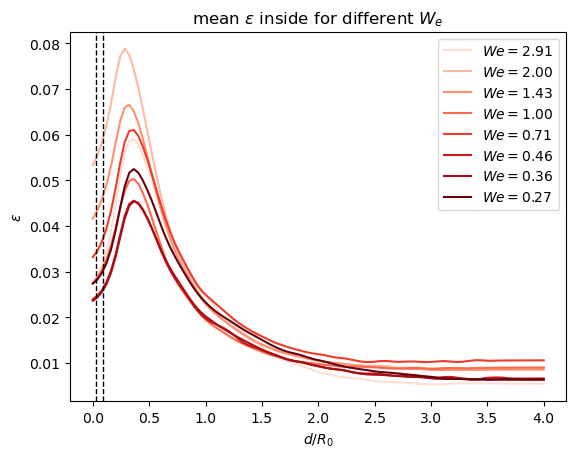

In [319]:
cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)
i=0
opti={}
for key in gamma_sort:
    if key<700:
        pass
    if key==8:
        continue
    indicemax=np.argmax(dissipationint[key][0,:])
#     indice=np.logical_and(-dist<-0.04*8,-dist>-0.16*8)
#     print(key, int(dissipationint[key][2, 0]))
#     print(key, int(dissipationext[key][2, 0])
    line, = plt.plot(dist/R0, dissipationint[key][0,:],color=cmap(i+1),label = f'$We = {pref/key:.2f}$')
    popt,pcov=curve_fit(expo_decr,dist[indicemax:]/R0,dissipationint[key][0,indicemax:])
    if key not in opti:
        opti[key]=np.zeros(3)
    opti[key] = popt
    
    i+=1

plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$\epsilon$')
print(opti)
plt.axvline(dx/R0,color='k',linestyle='--',lw=1)
plt.axvline(3*dx/R0,color='k',linestyle='--',lw=1)
plt.title(r'mean $\epsilon $ inside for different $W_e$ ')
# plt.savefig(folderfig + 'mean_dissipation_inside_We.pdf',bbox_inches='tight')

/tmp/ipykernel_6504/1864817528.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)


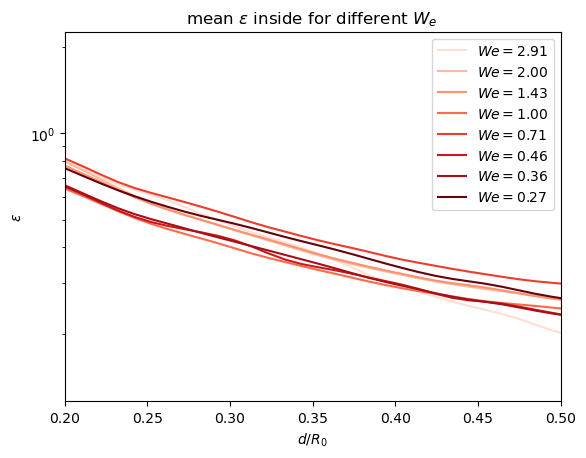

In [272]:
cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)
i=0
for key in gamma_sort:
    if key<700:
        pass
    if key==8:
        continue
    indicemax=np.argmax(dissipationint[key][0,:])
#     indice=np.logical_and(-dist<-0.04*8,-dist>-0.16*8)
#     print(key, int(dissipationint[key][2, 0]))
#     print(key, int(dissipationext[key][2, 0])
    line, = plt.plot(dist[indicemax:]/R0, dissipationint[key][0,indicemax:],color=cmap(i+1),label = f'$We = {pref/key:.2f}$')

    
    i+=1

plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$\epsilon$')
plt.yscale('log')
plt.xlim(0.2,0.5)
plt.axvline(dx/R0,color='k',linestyle='--',lw=1)
plt.axvline(3*dx/R0,color='k',linestyle='--',lw=1)
plt.title(r'mean $\epsilon $ inside for different $W_e$ ')
plt.savefig(folderfig + 'mean_dissipation_inside_We_log.pdf',bbox_inches='tight')

/tmp/ipykernel_6504/975804689.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)


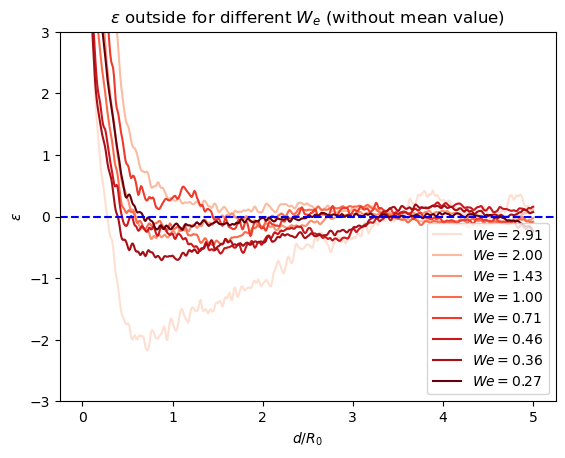

In [262]:
cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)
i=0
opti={}

for key in gamma_sort:
    if key<700:
        pass
    if key==8:
        continue
#     print(key, int(dissipationint[key][2, 0]))
#     print(key, int(dissipationext[key][2, 0])
    moy = np.sum(dissipationext[key][0,250:])/len(dist2[250:])
    line, = plt.plot(dist2/R0, dissipationext[key][0,:]-moy,color=cmap(i+1),label = f'$We = {pref/key:.2f}$')
    i+=1
# plt.yscale('log')
plt.legend()
plt.axhline(0,color='b',linestyle='--')
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$\epsilon$')
plt.ylim(-3,3)
plt.title(r'$\epsilon $ outside for different $W_e$ (without mean value) ')
plt.savefig(folderfig + 'diss_out_meanless_We_zoom.pdf',bbox_inches='tight')
# plt.axvline(dx/R0)
# plt.ylim(0.1,100)
# plt.xlim(0,1)

/tmp/ipykernel_6504/3641898758.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)


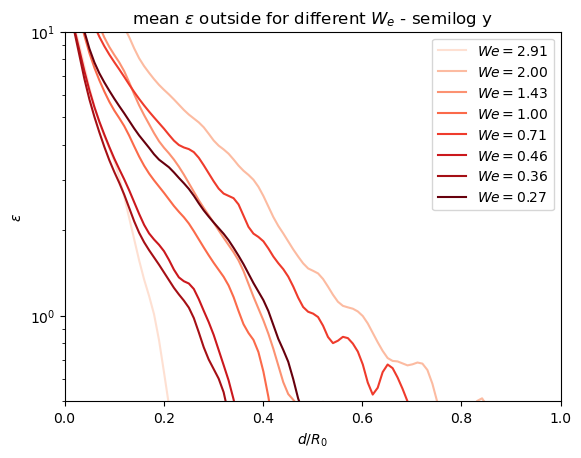

In [271]:
cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)
i=0
opti={}

for key in gamma_sort:
    if key<700:
        pass
    indicemax=np.argmax(dissipationext[key][0,:])
#     indice=np.logical_and(-dist<-0.04*8,-dist>-0.16*8)
#     print(key, int(dissipationint[key][2, 0]))
#     print(key, int(dissipationext[key][2, 0])
    moy = np.sum(dissipationext[key][0,-20:])/20
    line, = plt.plot(dist2/R0, dissipationext[key][0,:]-moy,color=cmap(i+1),label = f'$We = {pref/key:.2f}$')
    i+=1
# plt.yscale('log')
plt.legend()
plt.axhline(0,color='b',linestyle='--')
plt.yscale('log')
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$\epsilon$')
plt.ylim(0.5,10)
plt.xlim(0,1)
plt.title(r'mean $\epsilon $ outside for different $W_e$ - semilog y')
plt.savefig(folderfig + 'diss_out_meanless_log_y_We.pdf',bbox_inches='tight')

Text(0, 0.5, '$\\epsilon$')

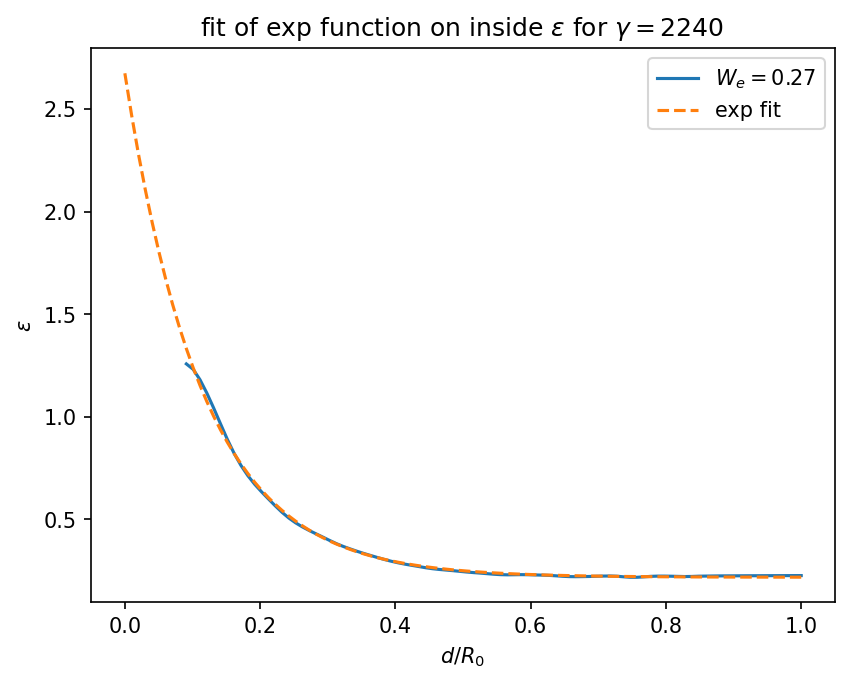

In [296]:
plt.figure(dpi=150)
gam = 800.
indicemax=np.argmax(dissipationint[gam][0,:])
plt.plot(dist[indicemax:]/R0, dissipationint[gam][0,indicemax:],label = f'$W_e = {pref/key:.2f}$')
plt.plot(dist/R0,expo_decr(dist/R0,opti[gam][0],opti[gam][1],opti[gam][2]) ,linestyle='--', label = f'exp fit')
plt.legend()
plt.title(r'fit of exp function on inside $\epsilon$ for $\gamma = 2240$ ')
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$\epsilon$')
# plt.savefig(folderfig + 'mean_diss_inside_fitted_We_gamma=2240.pdf',bbox_inches='tight')

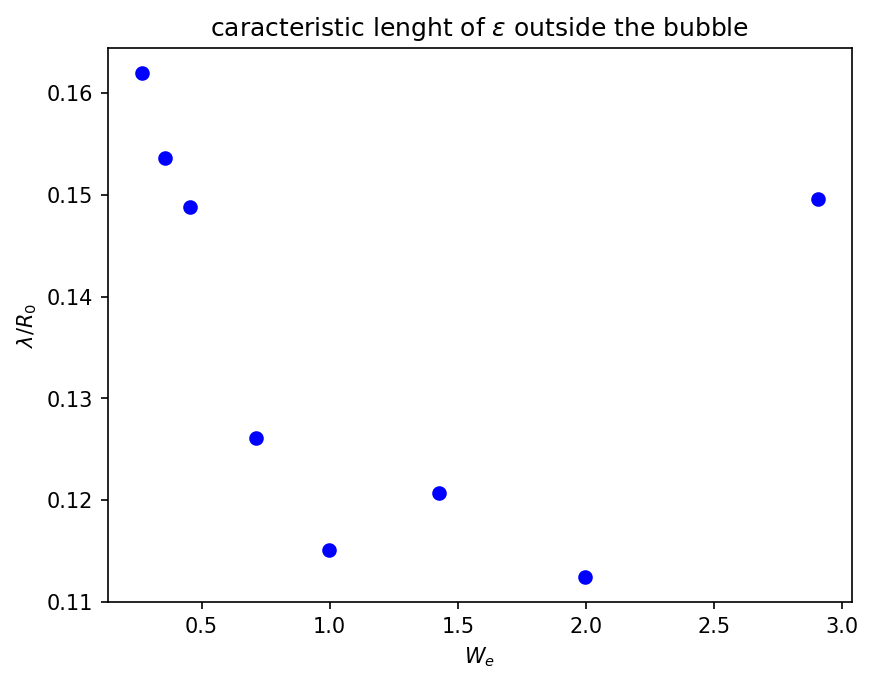

In [297]:
plt.figure(dpi=150)
for key in opti:
    plt.scatter(pref/key, opti[key][0],color='b')
plt.xlabel('$W_e$')
plt.ylabel('$\lambda/R_0$')
plt.title('caracteristic lenght of $\epsilon$ outside the bubble ')
plt.savefig(folderfig + 'diss_lenght_out_We.pdf',bbox_inches='tight')
    

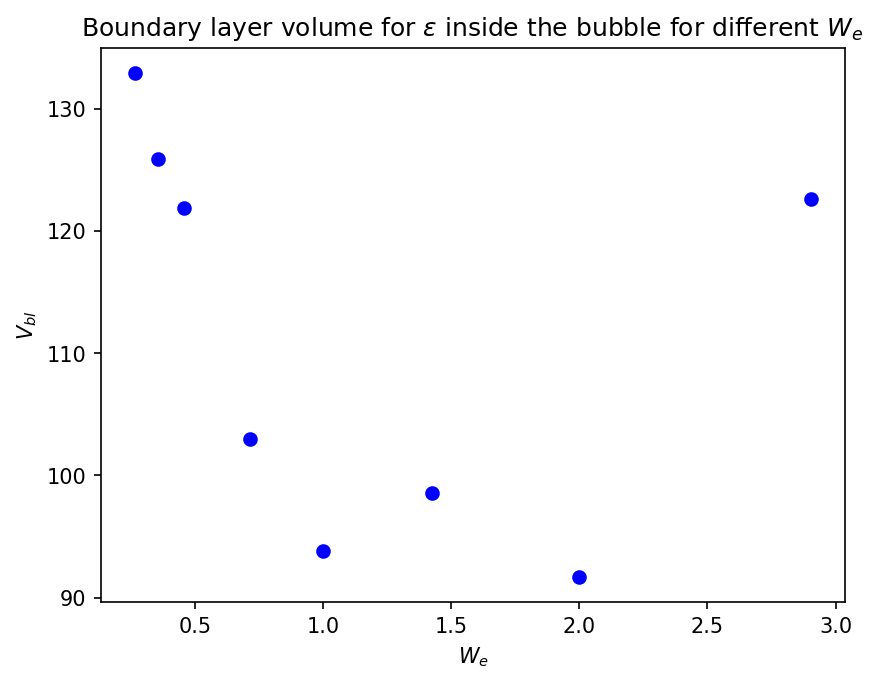

In [294]:
plt.figure(dpi=150)
for key in opti:
    plt.scatter(pref/key, 4/3*(np.pi)*((R0+opti[key][0])**3-R0**3),color='b')
plt.xlabel('$W_e$')
plt.ylabel('$V_{bl}$')
plt.title('Boundary layer volume for $\epsilon$ inside the bubble for different $W_e$ ')
plt.savefig(folderfig + 'boundary_layer_in_We.pdf',bbox_inches='tight')

/tmp/ipykernel_6504/4098667192.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)
/tmp/ipykernel_6504/4098667192.py:11: RuntimeWarning: invalid value encountered in double_scalars
  integrale[i]=np.trapz((dissipationext[key][0,:i+1]-moy)*4*np.pi*(1+dist2[:i+1]/R0)**2,dist2[:i+1]/R0)/(4/3*np.pi*((x/R0+1)**3-1))


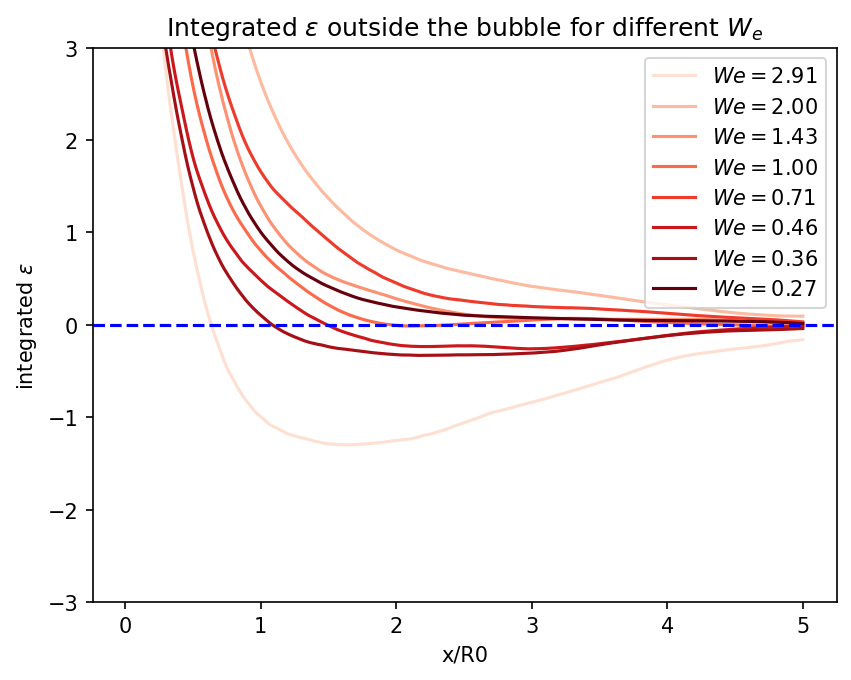

In [265]:
plt.figure(dpi=150)
cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)
integrale=np.zeros(len(dist2))
j=0
for key in gamma_sort:
    if key<700:
        pass
    i=0
    for x in dist2:
        moy = np.sum(dissipationext[key][0,-250:])/250
        integrale[i]=np.trapz((dissipationext[key][0,:i+1]-moy)*4*np.pi*(1+dist2[:i+1]/R0)**2,dist2[:i+1]/R0)/(4/3*np.pi*((x/R0+1)**3-1))

        i+=1
    plt.plot(dist2/R0,integrale,color=cmap(j+1),label = f'$We = {pref/key:.2f}$')
    j+=1

plt.legend()
plt.axhline(0,color='b',linestyle='--')
plt.xlabel('x/R0')
plt.ylabel(r'integrated $\epsilon$')
# plt.yscale('log')
plt.ylim(-3,3)
# plt.ylim(0.03,30)
plt.title(r'Integrated $\epsilon$ outside the bubble for different $W_e$')
plt.savefig(folderfig + 'integrate_diss_out_we')

/tmp/ipykernel_6504/1355898306.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)


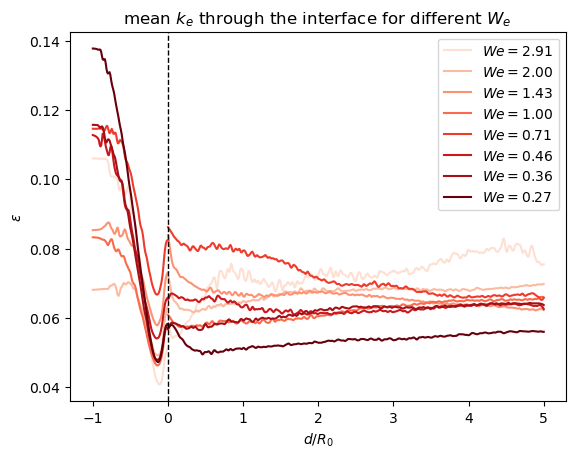

In [246]:
cmap = plt.cm.get_cmap('Reds', len(lgammas)+1)
i=0

for key in gamma_sort:
    if key<700:
        pass
    if key==8:
        continue
#     indicemax=np.argmax(dissipationint[key][0,:])
#     indice=np.logical_and(-dist<-0.04*8,-dist>-0.16*8)
#     print(key, int(dissipationint[key][2, 0]))
#     print(key, int(dissipationext[key][2, 0])
    line, = plt.plot(dist2/R0, kineticext[key][0,:]/850,color=cmap(i+1),label = f'$We = {pref/key:.2f}$')
    line, = plt.plot(dist/R0*(-1), kineticint[key][0,:],color=cmap(i+1))

    i+=1

plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$\epsilon$')
# plt.xlim(-0.5,0.5)
plt.axvline(0,color='k',linestyle='--',lw=1)
plt.title(r'mean $k_e $ through the interface for different $W_e$ ')
plt.savefig(folderfig + 'mean_kinetic_We.pdf',bbox_inches='tight')